## Task 1 - Zero-Shot Evaluation

In [1]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
CUDA   : 12.1
Torch  : 2.3.1+cu121
Device : NVIDIA GeForce RTX 3080
Sun Nov  9 20:04:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8              22W / 320W |     25MiB / 10240MiB |      0%      Default |
| 

In [2]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, AutoProcessor, CLIPVisionModel, logging
import clip
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings
import torch.nn.functional as F

/home/abat/conda_envs/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# 降噪：避免 tokenizers 在多工情境下噴警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 64                               # 3080 10GB 建議 32~64；不足再降
NUM_WORKERS = 2

print(f"Python: {torch.__version__}, Device: {DEVICE}")

processor = AutoProcessor.from_pretrained(MODEL_ID)
model     = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()




Python: 2.3.1+cu121, Device: cuda


/home/abat/conda_envs/clip/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [4]:
# ==== Flowers102 (torchvision) ====
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader

# 把 PIL 影像轉成 (3,224,224) 的 CLIP 規格 tensor
def clip_image_transform(image):
    px = processor(images=image, return_tensors="pt")["pixel_values"][0]  # (3,224,224)
    return px

flowers102_test_dts = Flowers102(
    root="./data",
    split="test",
    transform=clip_image_transform,
    download=True
)
print(f"Total test samples (Flowers102): {len(flowers102_test_dts)}")  # 6149

flowers102_test_loader = DataLoader(
    flowers102_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# 類別名稱（使用你上傳的 cat_to_name.json）
with open("./data/cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)
flowers102_class_names = [cat_to_name[str(i)] for i in range(1, 103)]


Total test samples (Flowers102): 6149


In [5]:
# ==== CUB-200-2011 (HF datasets) ====
from datasets import load_dataset

birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011", cache_dir="./data")
cub_bird_test_raw = birds_200["test"]
print(f"Total test samples (CUB): {len(cub_bird_test_raw)}")  # 5794

# 在 __getitem__ 階段就生出 pixel_values 與 label
def cub_transform(example):
    px = processor(images=example["image"], return_tensors="pt")["pixel_values"][0]  # (3,224,224)
    return {"pixel_values": px, "label": example["label"]}

cub_bird_test_dts = cub_bird_test_raw.with_transform(cub_transform)

# 強韌的 collate：把所有樣本疊成 (B,3,224,224)，label 成 (B,)
def _to_chw224(x: torch.Tensor) -> torch.Tensor:
    x = torch.as_tensor(x)
    if x.ndim == 3:
        # HWC -> CHW
        if x.shape[-1] == 3 and x.shape[0] != 3:
            x = x.permute(2, 0, 1)
        # 灰階擴通道
        if x.shape[0] == 1:
            x = x.repeat(3, 1, 1)
        elif x.shape[0] != 3:
            raise ValueError(f"Unexpected channel dim: {x.shape}")
    elif x.ndim == 2:
        x = x.unsqueeze(0).repeat(3, 1, 1)
    else:
        raise ValueError(f"Unexpected ndim {x.ndim} for image with shape {tuple(x.shape)}")
    if x.shape[1:] != (224, 224):
        x = F.interpolate(x.unsqueeze(0).float(), size=(224, 224),
                          mode="bilinear", align_corners=False).squeeze(0)
    return x.float()

def hf_collate_fn(batch):
    imgs = torch.stack([_to_chw224(b["pixel_values"]) for b in batch], dim=0)  # (B,3,224,224)
    labs = torch.tensor([int(b["label"]) for b in batch], dtype=torch.long)    # (B,)
    return {"pixel_values": imgs, "label": labs}

from torch.utils.data import DataLoader
cub_bird_test_loader = DataLoader(
    cub_bird_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

# 類別名稱由 HF features 提供
cub_bird_class_names = cub_bird_test_raw.features["label"].names


Total test samples (CUB): 5794


In [16]:
# ==== Zero-shot helpers ====

# 提示模板（可自行增減）
prompt_templates = [
    "a photo of a {}.",
    "a photo of {}.",
    "photo of {}.",
    "an image of a {}.",
    "an image of {}.",
    "image of {}.",
    "represent {}"
]

@torch.no_grad()
def zeroshot_eval_all_prompts(dataloader, class_names, templates):
    """
    一次建立全部 prompt 的文字特徵，對每張圖片同時計算 6 種 prompt 的預測。
    回傳: list[float]，每個模板的準確率
    """
    T = len(templates)
    C = len(class_names)

    # 1. 一次建立全部文字特徵 (T, C, D)
    text_features_all = []
    for tpl in templates:
        texts = [tpl.format(c) for c in class_names]
        inputs = processor(text=texts, return_tensors="pt", padding=True).to(DEVICE)
        feats = model.get_text_features(**inputs)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_features_all.append(feats)
    text_features_all = torch.stack(text_features_all, dim=0)  # (T, C, D)

    # 初始化統計
    correct_per_prompt = torch.zeros(T, device="cpu")
    total_samples = 0

    # 2. 評估
    for batch in tqdm(dataloader, desc="Zero-Shot (6 prompts together)"):
        if isinstance(batch, dict):
            images, labels = batch["pixel_values"], batch["label"]
        else:
            images, labels = batch
        if isinstance(images, list):
            images = torch.stack(images, dim=0)
        if images.ndim == 4 and images.shape[1] != 3 and images.shape[-1] == 3:
            images = images.permute(0, 3, 1, 2)

        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        B = images.size(0)

        # encode image only once
        img_feats = model.get_image_features(pixel_values=images)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)  # (B, D)

        # 3. 對每個 prompt 的文字特徵各自計算相似度
        for t in range(T):
            logits = 100.0 * img_feats @ text_features_all[t].T  # (B, C)
            preds  = logits.argmax(dim=-1)
            correct_per_prompt[t] += (preds == labels).sum().cpu()
        total_samples += B

    accs = (correct_per_prompt / total_samples).tolist()
    return accs

In [17]:
print("--- Starting Method 1: Zero-Shot Classification ---")

flowers_acc_list = zeroshot_eval_all_prompts(flowers102_test_loader, flowers102_class_names, prompt_templates)


--- Starting Method 1: Zero-Shot Classification ---


Zero-Shot (6 prompts together): 100%|██████████| 97/97 [01:12<00:00,  1.34it/s]


In [18]:
for temp, val in zip(prompt_templates, flowers_acc_list):
    print(f"\n[Flowers102] Template:{temp} Accuracy:{val * 100:.2f}%")


[Flowers102] Template:a photo of a {}. Accuracy:74.91%

[Flowers102] Template:a photo of {}. Accuracy:72.87%

[Flowers102] Template:photo of {}. Accuracy:72.53%

[Flowers102] Template:an image of a {}. Accuracy:75.15%

[Flowers102] Template:an image of {}. Accuracy:73.87%

[Flowers102] Template:image of {}. Accuracy:72.84%

[Flowers102] Template:represent {} Accuracy:53.96%


In [19]:
cub_acc_list     = zeroshot_eval_all_prompts(cub_bird_test_loader,     cub_bird_class_names,   prompt_templates)

    

Zero-Shot (6 prompts together): 100%|██████████| 91/91 [00:10<00:00,  8.91it/s]


In [20]:
for temp, val in zip(prompt_templates, cub_acc_list):
    print(f"\n[Birds200] Template:{temp} Accuracy:{val * 100:.2f}%")


[Birds200] Template:a photo of a {}. Accuracy:26.74%

[Birds200] Template:a photo of {}. Accuracy:26.74%

[Birds200] Template:photo of {}. Accuracy:25.27%

[Birds200] Template:an image of a {}. Accuracy:24.54%

[Birds200] Template:an image of {}. Accuracy:28.94%

[Birds200] Template:image of {}. Accuracy:26.01%

[Birds200] Template:represent {} Accuracy:19.41%


In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Optional

@torch.no_grad()
def visualize_multi_prompt_compact_indices(
    dataset,
    class_names: List[str],
    templates: List[str],
    indices: Optional[List[int]] = None,
    num_images: int = 16,
    cols: int = 4,
    dataset_name: str = "Dataset",
    save_path: Optional[str] = None,
    text_features_all: Optional[torch.Tensor] = None,  # (T,C,D) 可選：外部先算好丟進來更快
    font_size: int = 8,
):
    """
    高密度多 prompt 可視化（右側6行文字）：
      - 支援 indices；預設顯示 16 張（4x4）
      - Flowers / CUB 都可；自動修正灰階/HWC/多餘 batch 維
      - 綠色=正確，紅色=錯誤；並加上 ✓ / ✗
      - 可傳入 text_features_all 以避免重算
    """
    # ------- 取樣本 & 邊界檢查 -------
    ds_len = len(dataset)
    if indices is None:
        indices = list(range(min(num_images, ds_len)))
    else:
        indices = indices[:num_images]
        for i in indices:
            if i < 0 or i >= ds_len:
                raise IndexError(f"indices 包含越界索引 {i}（dataset 長度 {ds_len}）")

    imgs, labs = [], []
    for idx in indices:
        sample = dataset[idx]
        # CUB (HF) -> dict; Flowers (torchvision) -> (image, label)
        if isinstance(sample, dict):
            px = torch.as_tensor(sample["pixel_values"])
            # (1,3,224,224) -> (3,224,224)
            if px.ndim == 4:
                px = px.squeeze(0)
            # (H,W) -> (3,H,W) 灰階
            if px.ndim == 2:
                px = px.unsqueeze(0).repeat(3, 1, 1)
            # (H,W,3) -> (3,H,W)
            if px.ndim == 3 and px.shape[-1] == 3 and px.shape[0] != 3:
                px = px.permute(2, 0, 1)
            # 如尺寸有偏差，補內插到 224
            if px.shape[1:] != (224, 224):
                px = F.interpolate(px.unsqueeze(0).float(), size=(224, 224),
                                   mode="bilinear", align_corners=False).squeeze(0)
            imgs.append(px)
            labs.append(sample["label"])
        elif isinstance(sample, tuple) and len(sample) == 2:
            px = sample[0]
            if isinstance(px, torch.Tensor) and px.ndim == 4:
                px = px.squeeze(0)
            if px.ndim == 2:
                px = px.unsqueeze(0).repeat(3, 1, 1)
            if px.shape[1:] != (224, 224):
                px = F.interpolate(px.unsqueeze(0).float(), size=(224, 224),
                                   mode="bilinear", align_corners=False).squeeze(0)
            imgs.append(px)
            labs.append(sample[1])
        else:
            raise ValueError(f"未知的樣本格式：{type(sample)}")

    imgs = torch.stack(imgs, dim=0).to(DEVICE)          # (B,3,224,224)
    labs = torch.as_tensor(labs)                        # (B,)
    assert imgs.ndim == 4 and imgs.shape[1] == 3, f"Unexpected imgs shape {imgs.shape}"

    # ------- 編碼圖片（一次） -------
    # 與模型 dtype 對齊（如你在別處把 model.half()）
    imgs = imgs.to(model.dtype)
    img_feats = model.get_image_features(pixel_values=imgs)  # (B,D)
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

    # ------- 編碼 6 個 prompt 的文字特徵（一次；或用外部傳入） -------
    if text_features_all is None:
        tf_list = []
        for tpl in templates:
            texts = [tpl.format(c) for c in class_names]
            inputs = processor(text=texts, return_tensors="pt", padding=True).to(DEVICE)
            feats = model.get_text_features(**inputs)          # (C,D)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            tf_list.append(feats)
        text_features_all = torch.stack(tf_list, dim=0)        # (T,C,D)
    else:
        text_features_all = text_features_all.to(DEVICE)

    # ------- 一次性計算所有 prompt 的 logits / preds -------
    # logits: (T,B,C) = (B,D) · (T,C,D)^T  ->  Einsum 向量化
    logits = torch.einsum('bd,tcd->tbc', img_feats, text_features_all) * 100.0
    preds_matrix = logits.argmax(dim=2).cpu().T               # (B,T)

    # ------- 畫圖（固定 rows×cols） -------
    rows = int((len(indices) + cols - 1) // cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.axis("off")

        # 圖片（min-max 範圍映射顯示）
        img = imgs[i].detach().float().cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / max(1e-6, (img.max() - img.min()))
        ax.imshow(img)

        gt = int(labs[i])
        ax.set_title(f"{dataset_name} idx:{idx}\nGT: {class_names[gt]}", fontsize=font_size, pad=3)

        # 在軸外右側用座標系統排版文字（不受像素尺寸影響）
        y0, dy = 0.90, 0.12  # 起始 y & 行距（軸座標）
        for t, tpl in enumerate(templates):
            pred_idx = int(preds_matrix[i, t])
            ok = (pred_idx == gt)
            color = "#23a559" if ok else "#d43f3a"   # 綠 / 紅
            mark  = "✓" if ok else "✗"
            ax.text(1.02, y0 - t * dy,
                    f"[{t+1}] {class_names[pred_idx]} {mark}",
                    transform=ax.transAxes,
                    fontsize=font_size,
                    color=color,
                    va="top",
                    ha="left",
                    family="monospace")

    # 關掉多餘子圖
    for j in range(len(indices), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.7)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


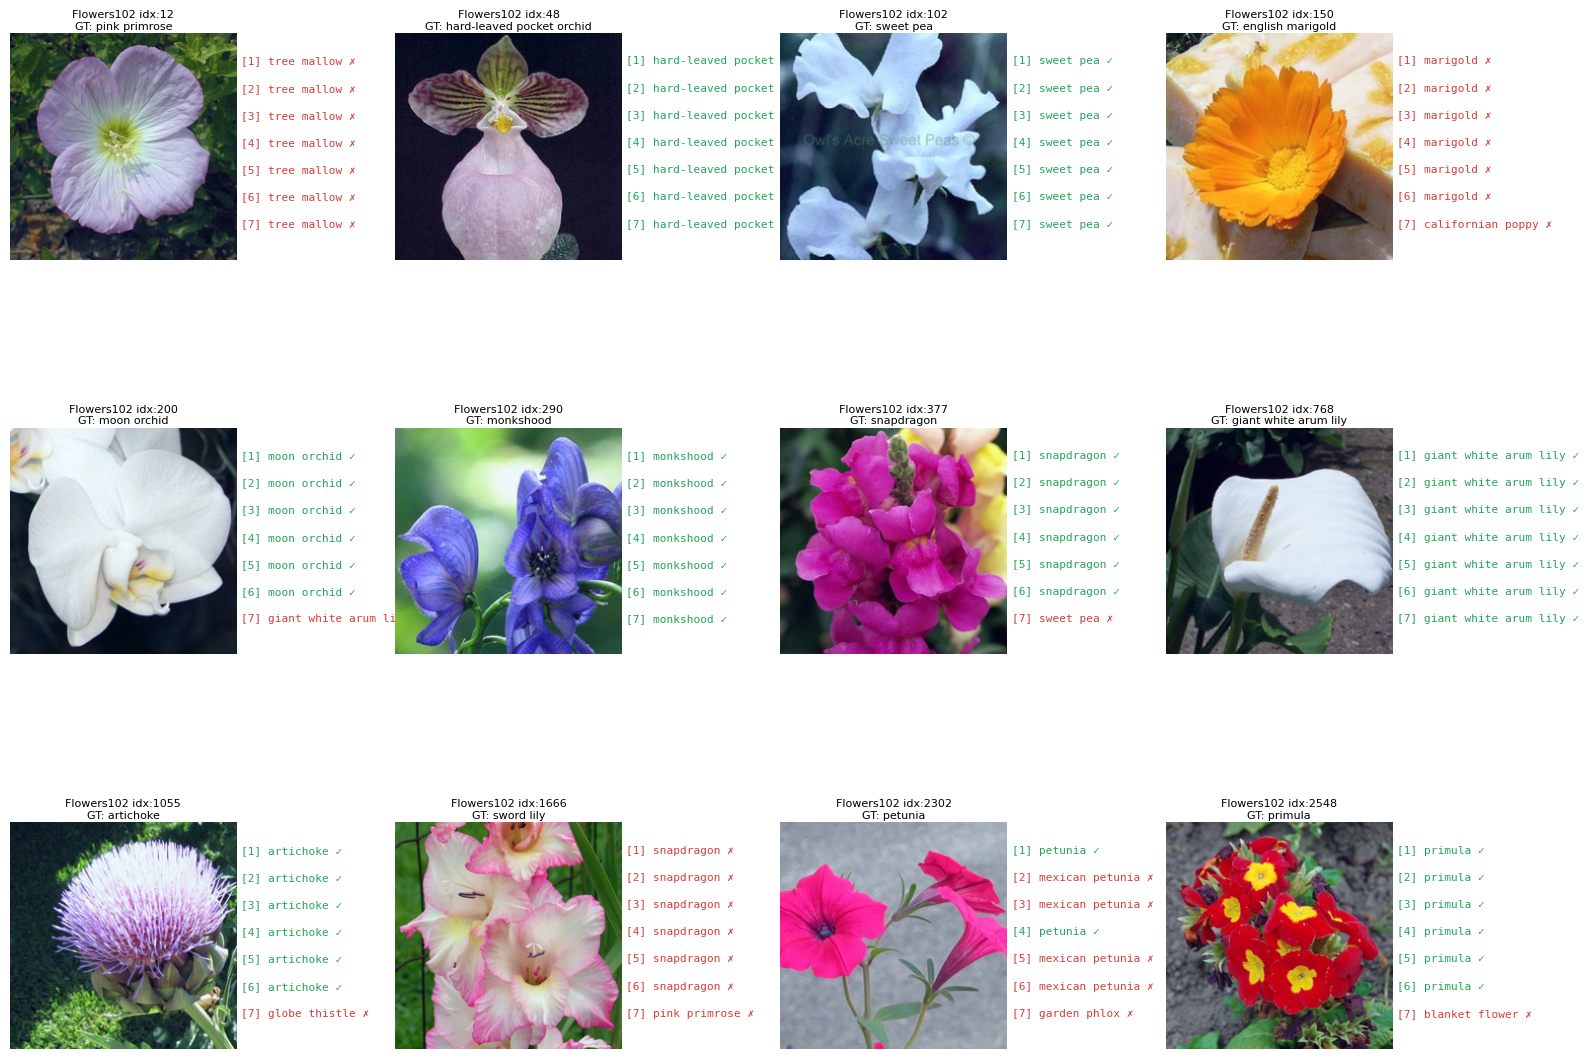

In [44]:

visualize_multi_prompt_compact_indices(
    flowers102_test_dts,        
    flowers102_class_names,     
    prompt_templates,           
    indices=[12, 48, 102, 150, 200, 290, 377, 768, 1055, 1666, 2302, 2548],
    num_images=12,
    cols=4,
    dataset_name="Flowers102"
)


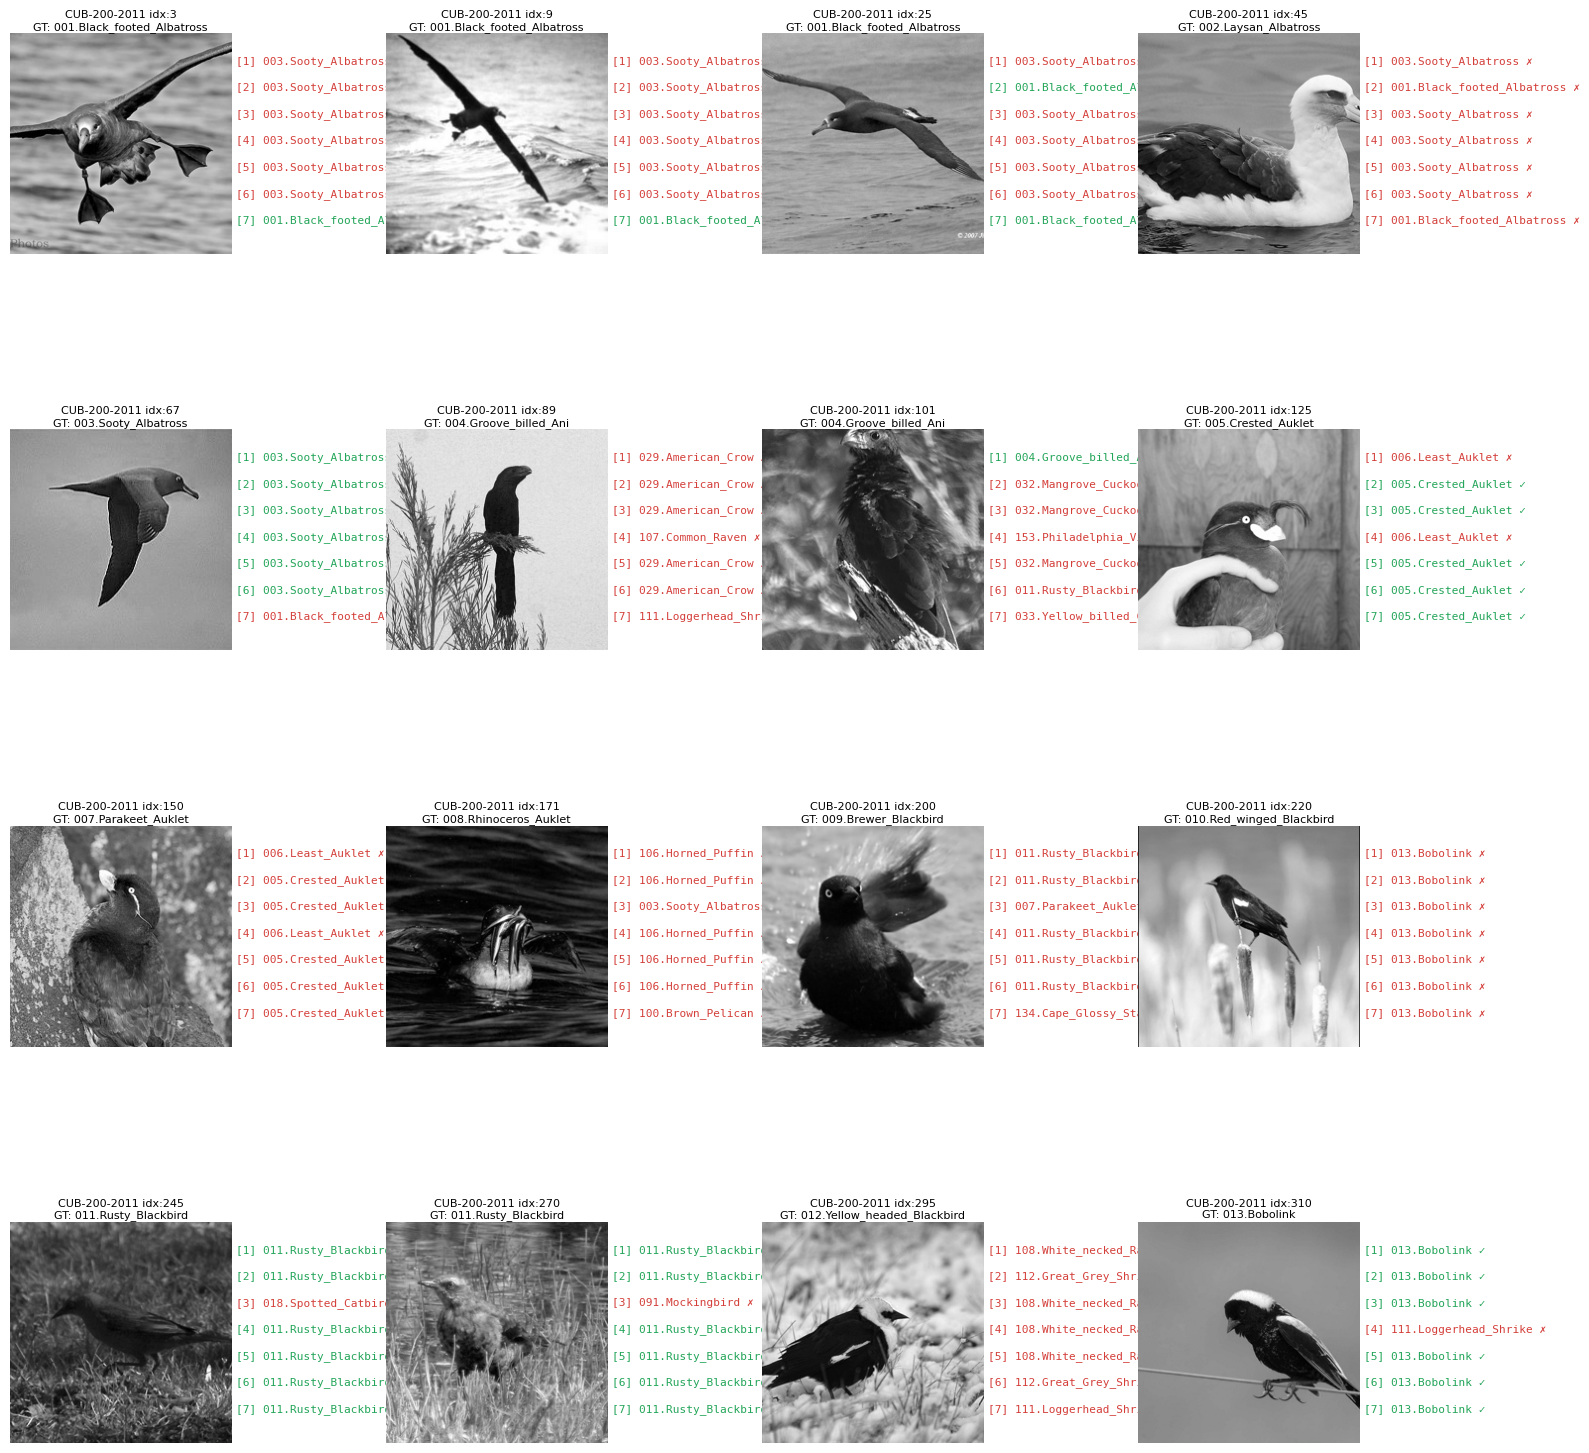

In [45]:
# 顯示 16 張鳥類圖片 (可指定索引或隨機)
visualize_multi_prompt_compact_indices(
    cub_bird_test_dts,          # HF dataset
    cub_bird_class_names,
    prompt_templates,
    indices=[3, 9, 25, 45, 67, 89, 101, 125, 150, 171, 200, 220, 245, 270, 295, 310],
    num_images=16,
    cols=4,
    dataset_name="CUB-200-2011"
)
